# À l'origine : le sac de mots

## Données

Repartons des données que nous avons mis en forme, et amenons progressivement une analyse plus avancée

In [1]:
import pandas as pd
df = pd.read_excel("../data/data_hal_crest.xlsx")
df.head()

,docid,title,abstract,abstract_eng,publicationDate_tdate,document_type,authors,date
0,3026577,"[""The effect of price magnitude on analysts' f...",['Recent research in finance shows that the ma...,['Recent research in finance shows that the ma...,2021-01-01T00:00:00Z,shs.eco,"['Tristan Roger', 'Wael Bousselmi', 'Patrick R...",2021-01-01
1,4358212,['Model-based Clustering with Missing Not At R...,"['Model-based unsupervised learning, as any le...","['Model-based unsupervised learning, as any le...",2024-06-18T00:00:00Z,stat.ml,"['Aude Sportisse', 'Matthieu Marbac', 'Fabien ...",2024-06-18
2,4996040,['Inferring the parameters of Taylor’s power l...,['Taylor’s power law of fluctuation scaling ha...,['Taylor’s power law of fluctuation scaling ha...,2025-11-26T00:00:00Z,stat,"['Lionel Truquet', 'Joel E. Cohen', 'Paul Douk...",2025-11-26
3,5357551,['Nonparametric intensity estimation of spatia...,['We propose a random forest estimator for the...,['We propose a random forest estimator for the...,2025-11-10T00:00:00Z,stat.me,"['Christophe Biscio', 'Frédéric Lavancier']",2025-11-10
4,3026615,['Impact of the Brexit vote announcement on lo...,['We examine how the Brexit announcement influ...,['We examine how the Brexit announcement influ...,2020-01-01T00:00:00Z,shs.eco,"['Wael Bousselmi', 'Patrick Sentis', 'Marc Wil...",2020-01-01


## Transformer le texte en nombres : le comptage de mots

- Détecter des patterns : regex https://regex101.com/
- Découper en mots et les compter
    - C'est quoi un mot ?
    - Comment on compte ?

### Avant le mot : le pattern

In [2]:
import re
c=re.compile(r"\bmodèle\b",re.I)
c.findall("Ceci est un modèle")

['modèle']

In [3]:
df["contains_ai"] = df["abstract"].apply(lambda x: bool(c.search(x)))
df["contains_ai"].value_counts()

contains_ai
False    2140
True      168
Name: count, dtype: int64

### Découper en mots

### Basic

In [4]:
import re
word_pattern = r"\w+"
tokens = re.findall(word_pattern, "Ceci est un test")
tokens

['Ceci', 'est', 'un', 'test']

Les limites ?

### Utiliser NLTK

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

word_tokenize("Ceci est un test")

Compter les bigrams

In [ ]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

def generate_bigrams_nltk(text):
    tokens = word_tokenize(text.lower())
    bigrams = list(ngrams(tokens, 2))
    return bigrams

### Préprocessing : nettoyer les données

- Beaucoup d'opérations de nettoyage, spécifiques à chaque tache

In [7]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

french_stopwords = list(set(stopwords.words("french")))
french_stopwords[0:10]


def generate_bigrams_nltk(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in french_stopwords]
    bigrams = list(ngrams(filtered_tokens, 2))
    return bigrams

#generate_bigrams_nltk(df["texte_net"].iloc[0])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilien/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## DFM

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# créer mon object de ML
vectorizer = CountVectorizer(stop_words=french_stopwords, 
                             ngram_range=(1, 1), 
                             max_features=800)

# appliquer sur les données
X = vectorizer.fit_transform(df["texte"])
X = pd.DataFrame(X.toarray(),columns=list(vectorizer.get_feature_names_out()))

In [ ]:
#vectorizer.get_feature_names_out()

array(['00', '000', '000e', ..., 'œuvre', 'œuvrent', 'œuvres'],
      dtype=object)

Ajouter les bigrams

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words=french_stopwords, ngram_range=(2, 2), max_features=300)
bigrammes = (
    pd.DataFrame(
        vectorizer.fit_transform(df["texte"]).toarray(),
        columns=vectorizer.get_feature_names_out(),
    )
    .T.sum(axis=1)
    .sort_values(ascending=False)
)
bigrammes

## Une version un peu plus avancée

- Term Frequency-Inverse Document Frequency
    - Amélioration du DTM
- Approche souvent utilisée pour mettre en valeur les mots les plus spécifiques
- `Scikit-learn` a `TfidfVectorizer`

$$\text{TF-IDF}(t, d, D) = \left( \frac{f_{t,d}}{n_d} \right) \times \log \left(\frac{N}{\text{df}_t} \right)
$$

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# créer un objet
vectorizer = TfidfVectorizer(stop_words=french_stopwords, 
                             ngram_range=(1, 1), 
                             max_features=800)

# applique 
X = vectorizer.fit_transform(df["abstract"])

# mettre en forme
X = pd.DataFrame(X.toarray(),columns=list(vectorizer.get_feature_names_out()))
X.loc[100].sort_values()

10            0.000000
plus          0.000000
plusieurs     0.000000
point         0.000000
points        0.000000
                ...   
adaptive      0.250362
the           0.251071
technique     0.257374
sampling      0.370746
importance    0.448065
Name: 100, Length: 800, dtype: float64

Une fois qu'on a une représentation

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

X = vectorizer.fit_transform(df["abstract"])
cosine_similarity(X[0], X[4])

array([[0.11864538]])

Toutes les distances

In [ ]:
distances = pd.DataFrame(pairwise_distances(X, metric="cosine"))
distances[10].idxmax()

### Application avec le clustering

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt



Z = linkage(X.toarray(), method='ward') 

Tree

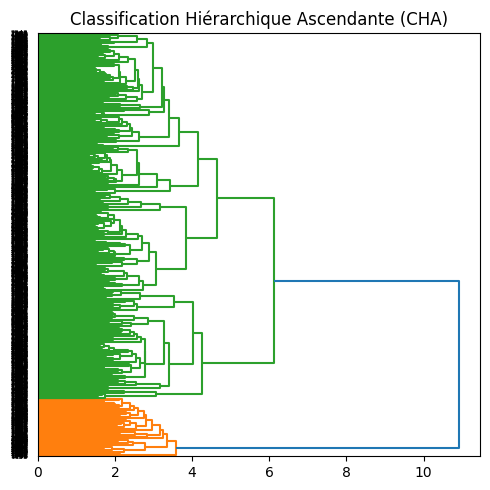

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
dendrogram(Z, orientation='right')
plt.title("Classification Hiérarchique Ascendante (CHA)")
plt.tight_layout()
plt.show()

Clustering

In [13]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=12,  linkage='ward')
labels = cluster.fit_predict(X.toarray())
df['cluster'] = labels

Contenu des clusters

In [15]:
df_w = pd.DataFrame(X.toarray(), 
                    columns=vectorizer.get_feature_names_out()) 
df_w[df["cluster"] == 3].max().sort_values()[-20:]

common           0.477176
research         0.477954
computational    0.479093
of               0.493992
will             0.501615
statistical      0.511561
issue            0.520095
note             0.531985
human            0.546034
status           0.546510
investment       0.550915
were             0.564728
economic         0.565123
the              0.602949
their            0.609557
correlation      0.643591
energy           0.656427
be               0.671069
10               0.728211
european         0.804705
dtype: float64

## Application : Faire un nuage de mots avec WordCloud

Un coup d'oeil à la [documentation](https://amueller.github.io/word_cloud/)